In [3]:
# Import our libraries
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, make_scorer
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load in our X (processed_fights.csv) and y (processed_data_labels.csv)
X = pd.read_csv('processed_fights.csv')
y = pd.read_csv('processed_data_labels.csv')

In [5]:
# Create our train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Training set shape:', X_train.shape, y_train.shape)
print('Testing set shape:', X_test.shape, y_test.shape)
print('Number of 0s in test =', (y_test == 0).sum().sum())
print('Number of 1s in test =', (y_test == 1).sum().sum())

Training set shape: (4164, 33) (4164, 1)
Testing set shape: (1042, 33) (1042, 1)
Number of 0s in test = 491
Number of 1s in test = 551


In [27]:
# Standardize non-categorical features
features_to_scale = ['f1_reach', 'f1_sapm', 'f1_slpm',
       'f1_stk_acc', 'f1_stk_def', 'f1_sub_avg', 'f1_td_acc', 'f1_td_avg',
       'f1_td_def', 'f1_weight', 'f2_reach', 'f2_sapm', 'f2_slpm',
       'f2_stk_acc', 'f2_stk_def', 'f2_sub_avg', 'f2_td_acc', 'f2_td_avg',
       'f2_td_def', 'f2_weight', 'f1_wins', 'f1_losses', 'f1_draws', 'f2_wins',
       'f2_losses', 'f2_draws', 'f1_age', 'f2_age', 'f1_height', 'f2_height']

scaler = StandardScaler()
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

# Save our scaler for later reference
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Accuracy: 0.7015355086372361


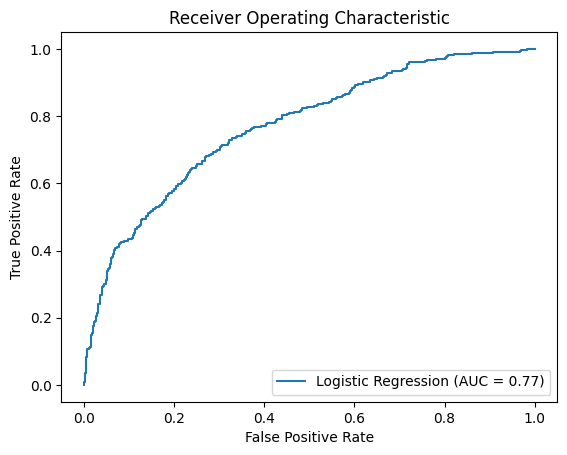

In [11]:
# Train a logistic regression model
lr = LogisticRegressionCV(penalty='l1', solver='liblinear', random_state=42)
lr.fit(X_train, y_train)

# Determine our logistic regression model accuracy and AUC
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print('Accuracy:', accuracy)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [10]:
with open('models/lr.pkl', 'wb') as f:
    pickle.dump(lr, f)

In [30]:
# Train on multiple models
classifiers = [
    LogisticRegressionCV(random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
]

classifiers_names = [
    'Logistic Regression',
    'K Neighbors',
    'Decision Tree Classifier',
    'RandomForest Classifier',
    'GradientBoostingClassifier',
    'AdaBoostClassifier'
]

for index, clf in enumerate(classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    print(classifiers_names[index])
    print('Accuracy:', accuracy)
    print('AUC: %0.2f' % roc_auc)
    print()

    with open('models/{}.pkl'.format(classifiers_names[index]), 'wb') as f:
        pickle.dump(clf, f)


Logistic Regression
Accuracy: 0.6880998080614203
AUC: 0.76

K Neighbors
Accuracy: 0.5863723608445297
AUC: 0.61

Decision Tree Classifier
Accuracy: 0.6074856046065259
AUC: 0.61

RandomForest Classifier
Accuracy: 0.6669865642994242
AUC: 0.74

GradientBoostingClassifier
Accuracy: 0.7072936660268714
AUC: 0.79

AdaBoostClassifier
Accuracy: 0.6986564299424184
AUC: 0.78



Accuracy: 0.7072936660268714


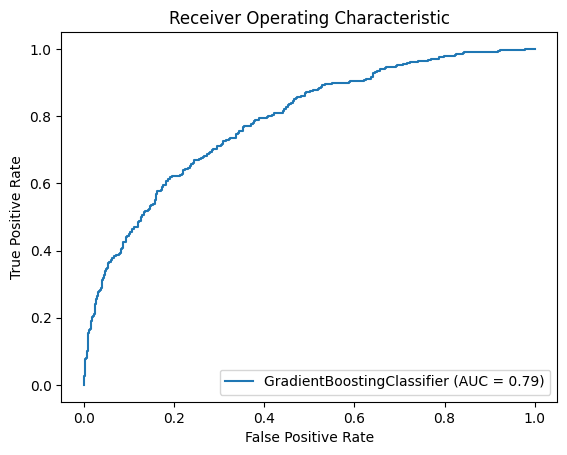

In [31]:
# Train a GradientBoosting classifier model
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

# Determine our gbc model accuracy and AUC
y_pred = gbc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print('Accuracy:', accuracy)
plt.plot(fpr, tpr, label='GradientBoostingClassifier (AUC = %0.2f)' % roc_auc)
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [32]:
""" Now let us do some GridSearchCV for GradientBoostingClassifier. """

# Define the Gradient Boosting Classifier model
gbc_gs = GradientBoostingClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4]
}

# Define the evaluation metric
scorer = make_scorer(accuracy_score)

# Perform grid search with cross-validation
grid_search = GridSearchCV(gbc_gs, param_grid, scoring=scorer, cv=5, verbose=1)
grid_search.fit(X, y)

# Print the best parameters and the corresponding accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Best Model: ", grid_search.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best Model:  GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42)


Accuracy: 0.7015355086372361


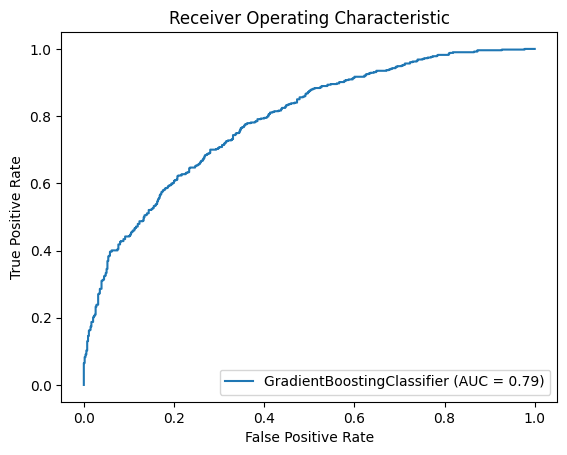

In [33]:
# Train a GradientBoosting classifier model
gbc = GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=2, n_estimators=200)
gbc.fit(X_train, y_train)

# Determine our gbc model accuracy and AUC
y_pred = gbc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print('Accuracy:', accuracy)
plt.plot(fpr, tpr, label='GradientBoostingClassifier (AUC = %0.2f)' % roc_auc)
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

with open('models/gbc_gs.pkl', 'wb') as f:
    pickle.dump(gbc, f)

In [38]:
weight_class = input("Enter weight class: ")
f1_reach = input("Enter fighter 1's reach: ")
f1_sapm = input("Enter fighter 1's SApM: ")
f1_slpm = input("Enter fighter 1's SLpM: ")
f1_stance = input("Enter fighter 1's stance: ")
f1_stk_acc = input("Enter fighter 1's stk_acc: ")
f1_stk_def = input("Enter fighter 1's stk_def: ")
f1_sub_avg = input("Enter fighter 1's sub_avg: ")
f1_td_acc = input("Enter fighter 1's td_acc: ")
f1_td_avg = input("Enter fighter 1's td_avg: ")
f1_td_def = input("Enter fighter 1's td_def: ")
f1_weight = input("Enter fighter 1's weight: ")
f2_reach = input("Enter fighter 2's reach: ")
f2_sapm = input("Enter fighter 2's SApM: ")
f2_slpm = input("Enter fighter 2's SLpM: ")
f2_stance = input("Enter fighter 2's stance: ")
f2_stk_acc = input("Enter fighter 2's stk_acc: ")
f2_stk_def = input("Enter fighter 2's stk_def: ")
f2_sub_avg = input("Enter fighter 2's sub_avg: ")
f2_td_acc = input("Enter fighter 2's td_acc: ")
f2_td_avg = input("Enter fighter 2's td_avg: ")
f2_td_def = input("Enter fighter 2's td_def: ")
f2_weight = input("Enter fighter 2's weight: ")
f1_wins = input("Enter fighter 1's wins: ")
f1_losses = input("Enter fighter 1's losses: ")
f1_draws = input("Enter fighter 1's draws: ")
f2_wins = input("Enter fighter 2's wins: ")
f2_losses = input("Enter fighter 2's losses: ")
f2_draws = input("Enter fighter 2's draws: ")
f1_age = input("Enter fighter 1's age: ")
f2_age = input("Enter fighter 2's age: ")
f1_height = input("Enter fighter 1's height: ")
f2_height = input("Enter fighter 2's height: ")


In [35]:
features_names = [
    'weight_class', 'f1_reach', 'f1_sapm', 'f1_slpm', 'f1_stance',
    'f1_stk_acc', 'f1_stk_def', 'f1_sub_avg', 'f1_td_acc', 'f1_td_avg',
    'f1_td_def', 'f1_weight', 'f2_reach', 'f2_sapm', 'f2_slpm', 'f2_stance',
    'f2_stk_acc', 'f2_stk_def', 'f2_sub_avg', 'f2_td_acc', 'f2_td_avg',
    'f2_td_def', 'f2_weight', 'f1_wins', 'f1_losses', 'f1_draws', 'f2_wins',
    'f2_losses', 'f2_draws', 'f1_age', 'f2_age', 'f1_height', 'f2_height'
]

features = [
    [weight_class], [f1_reach], [f1_sapm], [f1_slpm], [2],
    [f1_stk_acc], [f1_stk_def], [f1_sub_avg], [f1_td_acc], [f1_td_avg],
    [f1_td_def], [f1_weight], [f2_reach], [f2_sapm], [f2_slpm], [f2_stance],
    [f2_stk_acc], [f2_stk_def], [f2_sub_avg], [f2_td_acc], [f2_td_avg],
    [f2_td_def], [f2_weight], [f1_wins], [f1_losses], [f1_draws], [f2_wins],
    [f2_losses], [f2_draws], [f1_age], [f2_age], [f1_height], [f2_height]
]

features_dict = dict(zip(features_names, features))
submitted_df = pd.DataFrame(features_dict)
print(submitted_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   weight_class  1 non-null      object
 1   f1_reach      1 non-null      object
 2   f1_sapm       1 non-null      object
 3   f1_slpm       1 non-null      object
 4   f1_stance     1 non-null      int64 
 5   f1_stk_acc    1 non-null      object
 6   f1_stk_def    1 non-null      object
 7   f1_sub_avg    1 non-null      object
 8   f1_td_acc     1 non-null      object
 9   f1_td_avg     1 non-null      object
 10  f1_td_def     1 non-null      object
 11  f1_weight     1 non-null      object
 12  f2_reach      1 non-null      object
 13  f2_sapm       1 non-null      object
 14  f2_slpm       1 non-null      object
 15  f2_stance     1 non-null      object
 16  f2_stk_acc    1 non-null      object
 17  f2_stk_def    1 non-null      object
 18  f2_sub_avg    1 non-null      object
 19  f2_td_acc   

In [39]:
features_to_scale = ['f1_reach', 'f1_sapm', 'f1_slpm',
       'f1_stk_acc', 'f1_stk_def', 'f1_sub_avg', 'f1_td_acc', 'f1_td_avg',
       'f1_td_def', 'f1_weight', 'f2_reach', 'f2_sapm', 'f2_slpm',
       'f2_stk_acc', 'f2_stk_def', 'f2_sub_avg', 'f2_td_acc', 'f2_td_avg',
       'f2_td_def', 'f2_weight', 'f1_wins', 'f1_losses', 'f1_draws', 'f2_wins',
       'f2_losses', 'f2_draws', 'f1_age', 'f2_age', 'f1_height', 'f2_height']

print(submitted_df.iloc[0])
#submitted_df[features_to_scale] = scaler.transform(submitted_df[features_to_scale])

weight_class     
f1_reach         
f1_sapm          
f1_slpm          
f1_stance       2
f1_stk_acc       
f1_stk_def       
f1_sub_avg       
f1_td_acc        
f1_td_avg        
f1_td_def        
f1_weight        
f2_reach         
f2_sapm          
f2_slpm          
f2_stance        
f2_stk_acc       
f2_stk_def       
f2_sub_avg       
f2_td_acc        
f2_td_avg        
f2_td_def        
f2_weight        
f1_wins          
f1_losses        
f1_draws         
f2_wins          
f2_losses        
f2_draws         
f1_age           
f2_age           
f1_height        
f2_height        
Name: 0, dtype: object


In [40]:
prediction = gbc.predict(submitted_df)
prediction_probability = gbc.predict_proba(submitted_df)
print("The model predicts that fighter", int(prediction+1), "wins")
print("Confidence for that prediction is", float(prediction_probability[0][prediction]))

ValueError: could not convert string to float: ''

In [41]:
 import pandas as pd
 from sklearn.model_selection import train_test_split
 import tensorflow.compat.v1 as tf
 tf.disable_v2_behavior()
 import keras

In [42]:
# Load the preprocessed data and labels
subtracted_fights_data = pd.read_csv("new_processed_fights_data.csv")
labels = pd.read_csv("processed_data_labels.csv")

# Split the data and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(subtracted_fights_data, labels, test_size=0.2)

# Define the layers of the neural network
model = keras.Sequential([
    keras.layers.Dense(64, input_dim=X_train.shape[1], activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Make predictions on new data
predictions = model.predict(subtracted_fights_data)


Train on 4164 samples, validate on 1042 samples
Epoch 1/100
4164/4164 [==============================] - 1s 129us/sample - loss: 3.0142 - acc: 0.5689 - val_loss: 3.7948 - val_acc: 0.5288
Epoch 2/100
4164/4164 [==============================] - 0s 103us/sample - loss: 1.2687 - acc: 0.6165 - val_loss: 6.0126 - val_acc: 0.5144
Epoch 3/100
4164/4164 [==============================] - 0s 114us/sample - loss: 1.7177 - acc: 0.6117 - val_loss: 0.6100 - val_acc: 0.6967
Epoch 4/100
4164/4164 [==============================] - 0s 75us/sample - loss: 1.3385 - acc: 0.6071 - val_loss: 1.7638 - val_acc: 0.5969
Epoch 5/100
4164/4164 [==============================] - 0s 65us/sample - loss: 1.2139 - acc: 0.6362 - val_loss: 2.2328 - val_acc: 0.5739
Epoch 6/100
4164/4164 [==============================] - 0s 62us/sample - loss: 1.7370 - acc: 0.6081 - val_loss: 3.1255 - val_acc: 0.5384
Epoch 7/100
4164/4164 [==============================] - 0s 59us/sample - loss: 1.2073 - acc: 0.6371 - val_loss: 0.8310 -

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

# Load the preprocessed data and labels
data = pd.read_csv('new_processed_fights_data.csv')
#originalData = pd.read_csv('processed_fights.csv')
labels = pd.read_csv('processed_data_labels.csv')

# Add new feature to data set
#data['fighter1_win_pct'] = data['wins_fighter1'] / (data['wins_fighter1'] + data['losses_fighter1'])
#data['fighter2_win_pct'] = data['wins_fighter2'] / (data['wins_fighter2'] + data['losses_fighter2'])

# Drop the original wins, losses, and draws columns from the data set
#data = data.drop(columns=['wins_fighter1', 'losses_fighter1', 'draws_fighter1',
#                         'wins_fighter2', 'losses_fighter2', 'draws_fighter2'])

# Split the data and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

# Define the layers of the neural network
model = keras.Sequential([
    keras.layers.Dense(64, input_dim=X_train.shape[1], activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/100
131/131 [==============================] - 1s 4ms/step - loss: 4.7722 - accuracy: 0.5728 - val_loss: 0.7856 - val_accuracy: 0.6641
Epoch 2/100
131/131 [==============================] - 0s 3ms/step - loss: 1.3724 - accuracy: 0.6018 - val_loss: 2.2187 - val_accuracy: 0.5278
Epoch 3/100
131/131 [==============================] - 0s 3ms/step - loss: 1.5745 - accuracy: 0.6131 - val_loss: 2.4688 - val_accuracy: 0.5221
Epoch 4/100
131/131 [==============================] - 0s 3ms/step - loss: 1.3579 - accuracy: 0.6160 - val_loss: 0.8187 - val_accuracy: 0.6296
Epoch 5/100
131/131 [==============================] - 0s 3ms/step - loss: 1.5794 - accuracy: 0.6234 - val_loss: 2.7592 - val_accuracy: 0.5557
Epoch 6/100
131/131 [==============================] - 0s 3ms/step - loss: 1.9915 - accuracy: 0.6117 - val_loss: 5.4898 - val_accuracy: 0.4942
Epoch 7/100
131/131 [==============================] - 0s 3ms/step - loss: 2.4901 - accuracy: 0.6047 - val_loss: 1.6931 - val_accuracy: 0.6084

In [8]:
# Import the necessary libraries
from sklearn.ensemble import VotingClassifier

# Load the previously trained models
with open('models/lr.pkl', 'rb') as f:
    lr = pickle.load(f)

with open('models/gbc_gs.pkl', 'rb') as f:
    gbc = pickle.load(f)
    
with open('models/AdaBoostClassifier.pkl', 'rb') as f:
    abc = pickle.load(f)

#with open('rfc.pkl', 'rb') as f:
#    rfc = pickle.load(f)

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('lr', lr),
    ('gbc', gbc),
    ('abc',abc)
    ], voting='hard')

# Fit the ensemble model to the training data
ensemble_model.fit(X_train, y_train)

# Predict the labels of the test set using the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)

# Calculate the accuracy of the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print('Ensemble model accuracy:', accuracy_ensemble)

with open('models/voteClass.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)


Ensemble model accuracy: 0.7389635316698656


In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from mlxtend.classifier import StackingClassifier

# Load the data
X = pd.read_csv('processed_fights.csv')
y = pd.read_csv('processed_data_labels.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the pre-trained models
with open('models/lr.pkl', 'rb') as f:
    lr = pickle.load(f)

with open('models/gbc_gs.pkl', 'rb') as f:
    gbc = pickle.load(f)

with open('models/AdaBoostClassifier.pkl', 'rb') as f:
   abc = pickle.load(f)

# Initialize the StackingClassifier
stacked_model = StackingClassifier(
    classifiers=[lr, gbc,abc],
    meta_classifier=abc,
    use_probas=True,
    average_probas=False
)

# Train the stacked model using 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    stacked_model.fit(X_train_fold, y_train_fold)
    val_pred_fold = stacked_model.predict(X_val_fold)
    print('Fold accuracy:', accuracy_score(y_val_fold, val_pred_fold))

# Make predictions on the test set
test_pred = stacked_model.predict(X_test)
print('Test set accuracy:', accuracy_score(y_test, test_pred))

Fold accuracy: 0.7070828331332533
Fold accuracy: 0.7046818727490997
Fold accuracy: 0.7034813925570228
Fold accuracy: 0.7046818727490997
Fold accuracy: 0.6778846153846154
Test set accuracy: 0.710172744721689


In [53]:
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score

# Load the models
with open('models/lr.pkl', 'rb') as f:
    lr = pickle.load(f)
with open('models/gbc_gs.pkl', 'rb') as f:
    gbc = pickle.load(f)


# Load the data
X_test = pd.read_csv('processed_fights.csv')
y_test = pd.read_csv('processed_data_labels.csv')

# Make predictions on the test data
lr_pred = lr.predict(X_test)
gbc_pred = gbc.predict(X_test)


# Compute the accuracy of each model
lr_acc = accuracy_score(y_test, lr_pred)
gbc_acc = accuracy_score(y_test, gbc_pred)

# Print the accuracy of each model
print(f"Logistic Regression Accuracy: {lr_acc}")
print(f"Gradient Boosting Accuracy: {gbc_acc}")

# Create a blended prediction by taking a weighted average of the individual model predictions
blended_pred = (0.3 * lr_pred) + (0.5 * gbc_pred)

# Compute the accuracy of the blended prediction
blended_acc = accuracy_score(y_test, blended_pred)

# Print the accuracy of the blended prediction
print(f"Blended Accuracy: {blended_acc}")


Logistic Regression Accuracy: 0.5845178640030734
Gradient Boosting Accuracy: 0.506530925854783


ValueError: Classification metrics can't handle a mix of binary and continuous targets